In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style 

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
from IPython.display import display, HTML


import numpy as np

py.offline.init_notebook_mode(connected=True)
style.use('fivethirtyeight')
%matplotlib inline


## EDA

In [6]:
df_orders = pd.read_csv('~/Desktop/metisgh/McNulty_Project/Project Files/small_data/orders_subset.csv')
df_order_products_prior = pd.read_csv('~/Desktop/metisgh/McNulty_Project/Project Files/small_data/order_products__prior_subset.csv')
df_order_products_train = pd.read_csv('~/Desktop/metisgh/McNulty_Project/Project Files/small_data/order_products__train_subset.csv')
df_products = pd.read_csv('~/Desktop/metisgh/McNulty_Project/Project Files/small_data/products.csv')
df_aisles = pd.read_csv('~/Desktop/metisgh/McNulty_Project/Project Files/small_data/aisles.csv')
df_departments = pd.read_csv('~/Desktop/metisgh/McNulty_Project/Project Files/small_data/departments.csv')

### Orders
---
The orders table shows every order that has occured for each user as a single row. The orders are split into past orders as 'prior' and the most recent order as 'train'. The features will be created using the prior orders and tested on the train orders.

The orders table also given info for:

-**Day of Week**

-**Time of Day**

-**Days since the previous order was made**

In [7]:
df_orders.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0
5,1905727,50,prior,6,2,10,5.0
6,357849,50,prior,7,3,13,8.0
7,1673791,50,prior,8,6,14,3.0
8,1941871,50,prior,9,4,11,5.0
9,1431607,50,prior,10,2,10,5.0


### Aisles
---
The aisles table shows aisle types

In [8]:
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Departments
---
All types of department and corresponding id

In [9]:
df_departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### Order Products Prior
---
*Contains information to be used for creating features*

This table shows for each order, the type of product and order that it was entered into the cart. It also shows whether or not the product has been ordered before.

-**add_to_cart_order**: The order that the product (product_id) was added to the order (order_id)

-**reordered**: If the product has been ordered before (1) or not (0)

In [10]:
df_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


### Order Products Train
---
Contains the same information as order_products_prior except to be used for testing the model

In [11]:
df_order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


## Preliminary Plots

A majority of the orders are made over the weekend and during the middle of the day.

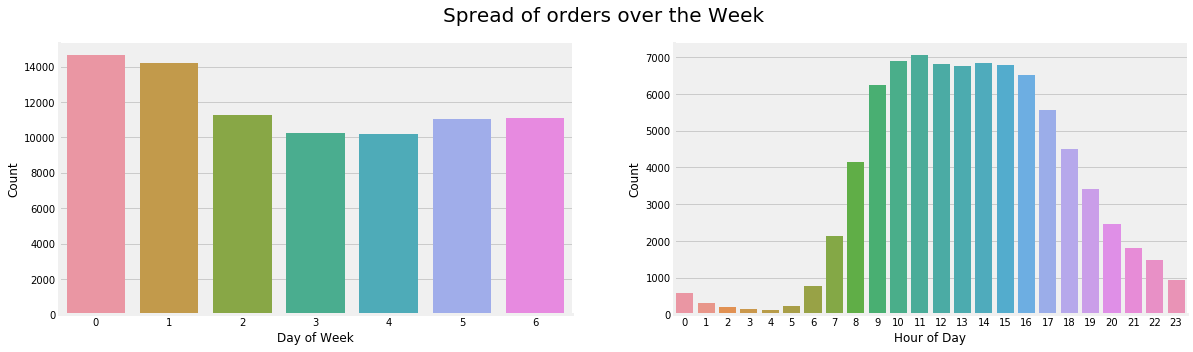

In [13]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))

sns.countplot(df_orders.order_dow, ax=ax1)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Count')

sns.countplot(df_orders.order_hour_of_day, ax=ax2)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Count')
sns.despine()
f.suptitle('Spread of orders over the Week', fontsize=20);


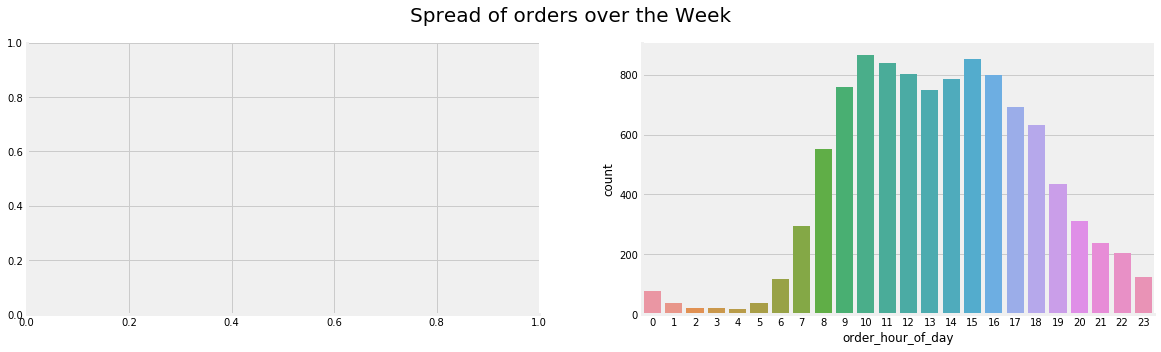

In [15]:
f, ax = plt.subplots(1,2, figsize=(18,5))

sns.countplot(df_orders.order_hour_of_day[df_orders.order_dow==3])
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Count')
sns.despine()
f.suptitle('Spread of orders over the Week', fontsize=20);

### Order counts by day over day of week

Many people order once a week. The spike at 30 could be people that ordered and never ordered again.

In [16]:
prior_count = df_orders[df_orders.eval_set=='prior'].groupby(['user_id'])['eval_set'].count().reset_index().rename(columns={'eval_set':'prior_count'})
total_counts = prior_count.groupby(['prior_count']).count().rename(columns={'user_id':'total_counts'}).reset_index()


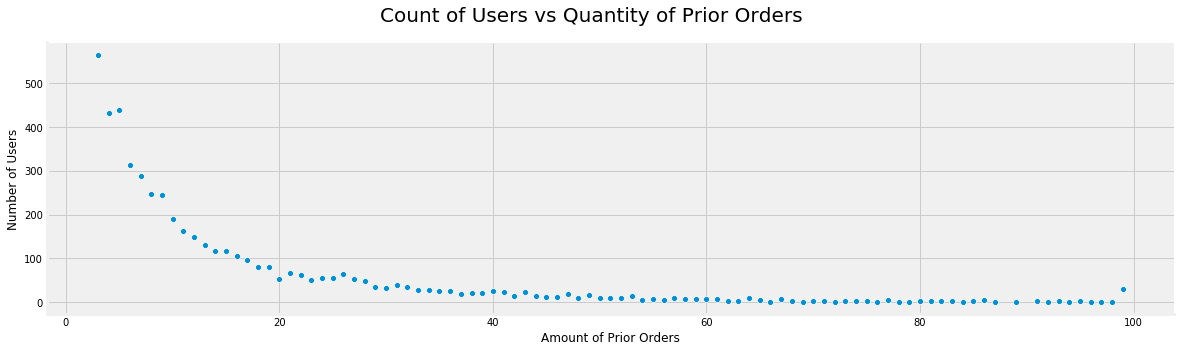

In [17]:
f, ax = plt.subplots(figsize=(18,5))
sns.scatterplot(total_counts.prior_count, total_counts.total_counts, ax=ax)
ax.set_xlabel('Amount of Prior Orders')
ax.set_ylabel('Number of Users')
sns.despine()
f.suptitle('Count of Users vs Quantity of Prior Orders', fontsize=20);

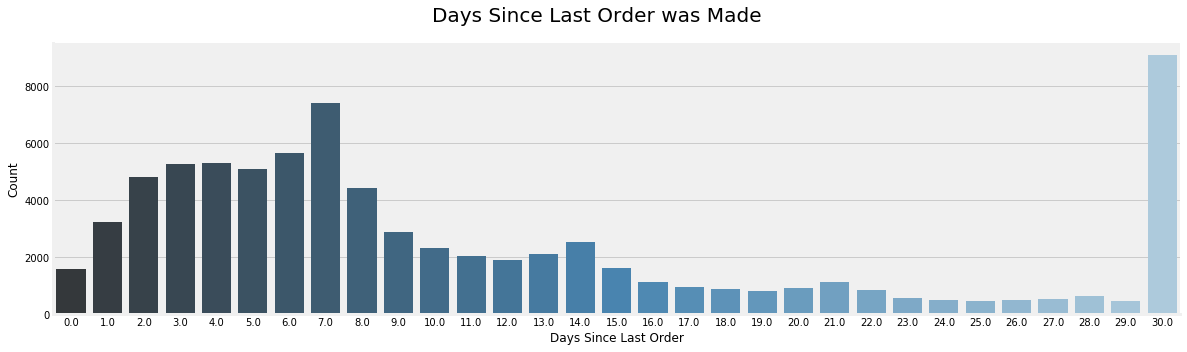

In [18]:
f, ax = plt.subplots(figsize=(18,5))
sns.countplot(df_orders.days_since_prior_order, palette=('Blues_d'), ax=ax)
ax.set_xlabel('Days Since Last Order')
ax.set_ylabel('Count')
sns.despine()
f.suptitle('Days Since Last Order was Made', fontsize=20);

In [19]:
df_orders.days_since_prior_order.values

array([nan, 10.,  9., ...,  6., 14., 14.])

In [20]:
x = df_orders.days_since_prior_order
data = [go.Histogram(x=x)]

py.offline.iplot(data, filename='basic histogram')

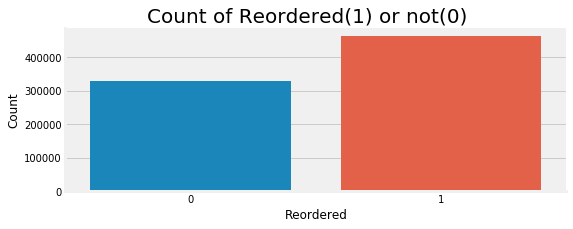

In [21]:
f, ax = plt.subplots(figsize=(8,3))
sns.countplot(df_order_products_prior.reordered, ax=ax)
ax.set_xlabel('Reordered')
ax.set_ylabel('Count')
sns.despine()
f.suptitle('Count of Reordered(1) or not(0)', fontsize=20);

In [22]:
order_product_name_prior = df_order_products_prior.merge(df_products, how='left', on='product_id') 

In [23]:
user_product_order_name = order_product_name_prior.merge(df_orders, how='left', on='order_id')

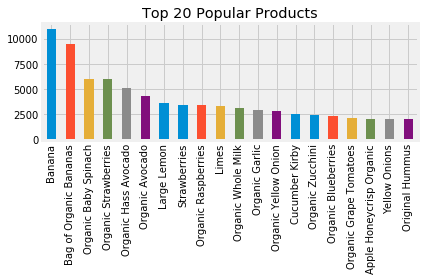

In [32]:
products_count = user_product_order_name['product_name'].value_counts()
fig = plt.figure()
products_count[0:20].plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Top 20 Popular Products')
plt.tight_layout()
plt.show()
fig.savefig('top_products.png');

In [32]:
products_tuple_list = [tuple(x) for x in products_count.reset_index().values]


In [30]:
dic = {}
for pair in products_tuple_list:
    key = pair[0]
    value = pair[1]
    if key in dic:
        reservedValue = dic[key]
        reservedValue += value 
    else:
        dic[key] = value

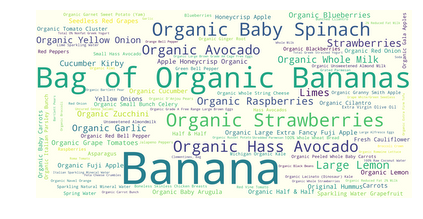

In [55]:
from os import path
from wordcloud import WordCloud

fig = plt.figure()
wordcloudData = WordCloud(width=4096,height=2048,
                          relative_scaling=1,
                          max_words = 100,
                          background_color='ivory').generate_from_frequencies(frequencies = dic)
plt.imshow(wordcloudData, interpolation='lanczos')
plt.axis("off")
plt.show()
fig.set_dpi(500)
fig.savefig('cloud.png')

In [44]:
df_orders[df_orders.]

0     NaN
1    10.0
2     9.0
3     6.0
4    11.0
Name: days_since_prior_order, dtype: float64

In [53]:

import plotly.figure_factory as ff

import numpy as np

x1 = df_orders.order_hour_of_day[df_orders.order_dow==0]
x2 = df_orders.order_hour_of_day[df_orders.order_dow==1]
x3 = df_orders.order_hour_of_day[df_orders.order_dow==2]
x4 = df_orders.order_hour_of_day[df_orders.order_dow==3]
x5 = df_orders.order_hour_of_day[df_orders.order_dow==4]
x6 = df_orders.order_hour_of_day[df_orders.order_dow==5]
x7 = df_orders.order_hour_of_day[df_orders.order_dow==6]

hist_data = [x1, x2, x3, x4, x5, x6, x7]

group_labels = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
colors = ['#7FFF00', '#32CD32', '#A9A9A9', '#A9A9A9', '#A9A9A9', '#A9A9A9', '#A9A9A9']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors, show_rug=False)

# Add title
fig['layout'].update(title='Number of Orders Throughout the Day')

# Plot!
py.offline.iplot(fig, filename='Curve and Rug')

In [56]:
x = ['(USER_Days Since Order)^2', 'USER_Total Aisles Ordered From', 
     'USER_PRODUCT Order Freq', 'PRODUCT_Average Cart Position',
     'USER_Days Since Last Order', 'USER_Average Days Since Last Order',
     'PRODUCT_ Standard Dev of Cart Position', 'USER_Average Cart Size']
y = [112, 94, 91, 91, 89, 81, 81, 77]

In [58]:
data = [go.Bar(
            x=y,
            y=x,
            orientation = 'h'
)]

py.offline.iplot(data, filename='horizontal-bar')